# Milestone 2: Setting up an Image Pipeline

Data is the crucial part of any machine learning project, no less (and sometimes more!) important than your choice of algorithm. Naturally, preparing a data pipeline that can handle pre-processing as well as augmentation of your dataset is typically the first piece of code that you write for an ML project.

PyTorch provides several tools that facilitate data loading and pre-processing. There are generally two classes that are involved in this task: a `torch.utils.data.Dataset` and a `torch.utils.data.DataLoader`. The Dataset class is the one that you will often need to write your own custom code for, that is going to inherit the abstract PyTorch class. There are at least two methods that you are going to have to override: `__len__` and `__getitem__`. These will allow you to get the size of your dataset via `len(dataset)` and access each datasample as `dataset[index]`. Additionally, for large datasets and/or high dimensional data, such as images, it is convenient to employ **lazy data loading**, where we are going to load each sample as needed, rather than keeping the entire dataset in the memory at once. 

The training sample returned by `dataset[index]` will be an image-label pair.



## Part A: the labeled Dataset

In [the provided dataset folder](MelanomaDetectionLabeled.zip), images containing melanoma have filenames that end with `*_1.jpg`, whereas benign images are named `*_0.jpg`. That is what we are going to use to get the labels that we return (along with the respective images) in the `__getitem__` method:

In [ ]:
import os
from os import listdir
from os.path import join
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

def is_image(filename):
    return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png"])

Number of images in the set:  200
Label:  1


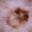

In [ ]:
class LabeledDataset(Dataset):

    def __init__(self, dir_path, transform=None):
        """
        Args:
            dir_path (string): Directory containing the images.
            transform (optional): Optional transform to be applied
                on an image.
        """

        self.transform = transform
        
        # The list of all the image file names (but not the images themselves!) will be read
        # when the Dataset object is initialized
        self.image_filenames = [join(dir_path, f) for f in listdir(dir_path) if is_image(f)]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):

        img_name = self.image_filenames[idx]
        
        # Here is where the image actually gets read:
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
            
        label = int(img_name[-5])

        return image, label
    
labeled_set = LabeledDataset('MelanomaDetectionLabeled/labeled')
print('Number of images in the set: ', len(labeled_set))
print('Label: ', labeled_set[42][1])
labeled_set[42][0]

### So what is this `transform` about?

What we have seen above is datasets returning images in the form of objects of type `PIL.PngImagePlugin.PngImageFile`. However, what we need to train a PyTorch model are PyTorch **tensors**. This requirement can be easily communicated to the dataset when we instantiate it via the `transform` argument:

In [ ]:
labeled_set = LabeledDataset('MelanomaDetectionLabeled/labeled', transform=transforms.ToTensor())

Now that we have the dataset, are we ready to use our data for training a model? Not quite yet. PyTorch has another class called `torch.utils.data.DataLoader` that takes care of splitting the data into minibatches of a given size, shuffling it if needed, and loading it in parallel by using multiprocessing workers. 

## Part B: the DataLoader

Batch labels:  tensor([1, 1, 0, 1])


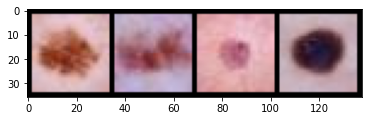

Batch labels:  tensor([1, 0, 0, 0])


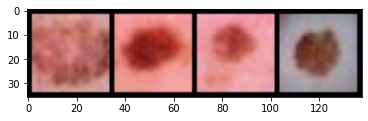

In [ ]:
labeled_loader = DataLoader(labeled_set, batch_size=4, shuffle=True, num_workers=4)

for batch_idx, batch in enumerate(labeled_loader):
    
    '''
    Here the batch contains both images and labels.
    '''
    
    # Stop after two batches
    if batch_idx == 2:
        break

    print("Batch labels: ", batch[1].data)
    
    # torchvision provides functions that facilitate displaying batches
    # of images that come in the form of PyTorch tensors:
    image_grid = torchvision.utils.make_grid(batch[0], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0))
    plt.pause(0.05)

(As you can see, the batches that are produced inside the loop are PyTorch tensors with the following shape:  *batch_size* x *number_of_channels* x *dimenstion_x* x *dimension_y*)

## Part C: Data Augmentation

While training our model, we are going to make use of the data augmentation techniques. In other words, we are going to randomly apply transformations to the images in our dataset, that result in (somewhat) different images that nevertheless correspond to the same class (melanoma positive or negative) as the original sample. The `torchvision.transforms` package contains a rich variety of transformations such as resizing, cropping, flipping, normalizing, rotations, changing colors, etc, that can be applied at random with a probability of your choice. Here the images in the dataset come in 32x32 pixels, and let us say that we would like to keep them that size for our model. (They are small enough that shrinking them would almost certainly be a bad idea, and enlarging them would only encrease the dimensionality of our inputs while keeping the amount of useful information unchanged). This leaves us with quite a few options, including e.g. horizontal and vertical flips, as well as rotations (keep in mind that occasionally rotations may result in removing the relevant part of the sample from the augmented image). 

We are only going to apply augmentation transforms to our training data, but not to the test set, to minimize any unintended effects. (In fact, if you are truly unsure of whether certain augmentations make sense for your data, it may be worthwhile to compare the final performance of two models, one trained with data augmentation and one without.)


In [ ]:
# Here I chose a limited range of rotations to minimize parts of the images that get omitted in the process
rotation = transforms.RandomChoice([transforms.RandomRotation([-3,3]),
                                    transforms.RandomRotation([87,93]), 
                                    transforms.RandomRotation([177,183]),
                                    transforms.RandomRotation([267, 273])])

augmentation = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(), 
                                   rotation])

Hence, the final version of the code that I will use for initializing the training and testing datasets is going to look like this:

In [ ]:
labeled_set = LabeledDataset('MelanomaDetectionLabeled/labeled',     
                             transform=transforms.Compose([augmentation, transforms.ToTensor()]))
                             
test_set = LabeledDataset('MelanomaDetectionLabeled/test',
                          transform=transforms.Compose([transforms.ToTensor()]))                            